<a href="https://colab.research.google.com/github/Vamsi-Malineni/CS5691_Machine_Learning_Models/blob/main/Regression/Task_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import math 
from random import sample
from mpl_toolkits import mplot3d
from numpy import genfromtxt
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [4]:
dataset = genfromtxt('/content/drive/MyDrive/Assignment1 datasets/function2_2d.csv', delimiter=',',skip_header=1)
dataset_1 = np.delete(dataset, 0, axis =1)

X = dataset_1[:,0:2]       
t = dataset_1[:,2]
 
d = 2                                                                   #No. of features
k = 7                                                                   #number of clusters
sigma = 100
N_total = len(X)                                                        # total number of dataset
N_train = int(0.7*N_total)                                              #Number of training data
N_test = int(0.2*N_total)                                               #Number of testind data
N_validate = int(0.1*N_total)                                           #Number of validation data
C = N_total//N_train                                                    #Number of times cross validation will run
t_train = t[0:N_train]                                                  #training data system output
t_test = t[N_train:(N_train+N_test)]                                    #testing data system output
t_validate = t[(N_train+N_test):(N_validate+N_train+N_test)]            #validating data system output
X_train = X[0:N_train,:]                                                #input data for training
X_test = X[N_train:(N_train + N_test) , :]                              #input data for testing
X_validate = X[(N_train + N_test):(N_validate+N_train+N_test), : ]      #input data for validation
lamda = np.exp(-18)                                                     #Regularization parameter


In [5]:
# Function for calculating K-Means Clustering 
def k_means_clustering(X,k,N_total,itteration,d):
    a = np.arange(N_total)      #getting length of X
    mean_index_initial = np.random.choice(a,k)     #getting random index from X
    mean_value_initial = X[mean_index_initial,:]
    z = np.zeros((N_total,k),dtype = int)
    N_index = np.zeros((k,1), dtype = int)
    mean_value = np.zeros((2,k,d),dtype = float)
    
    for p in range(itteration):
        q = 1
        #print(p)
        if(p==0):
            mean_value[q-1] = mean_value_initial
        else:
            mean_value[q] = update_mean(X,mean_value[q-1],z,k,N_total,N_index,d)
            compare = mean_value[q] == mean_value[q-1]
            if(compare.all()):
                mean_value_final = mean_value[q]
                print("Converged Means")
                break
            mean_value[q-1] = mean_value[q]
            mean_value[q] = 0
    return mean_value_final

def update_mean(X,mean_previous,z,k,N_total,N_index,d):
    a = np.zeros((k,1),dtype=float)
    z = np.zeros((N_total,k),dtype = float)
    mean_value = np.zeros((k,d), dtype= float)
    for l in range(N_total):
        a = X[l] - mean_previous
        b = np.sum(np.square(a),axis = 1)
        c = np.reshape(b,(k,1))
        index = np.argmin(c)
        z[l,index] = 1                            #Calculating Zni parameter

    for i in range(k):
        d = np.reshape(z[:,i],(N_total,1))
        N_index[i] = np.sum(d)
        mean_value[i,:] = (np.sum((d*X),axis = 0))/N_index[i]     #updating mean value     
    return mean_value

converged_mean = k_means_clustering(X,k,N_total,10000,d)   #Getting final mean after K-means clustering


Converged Means


# Without Regularization

+++++++++++++++++++++ WITHOUT REGULARIZATION +++++++++++++++++++++ 

Train Error(Without Regularization)
0.7010280650627834
Test Error(Without Regularization)
0.6047693619487691
Validate Error(Without Regularization)
0.7219278914269326




Text(0.5, 0, 'Target_Output-t')

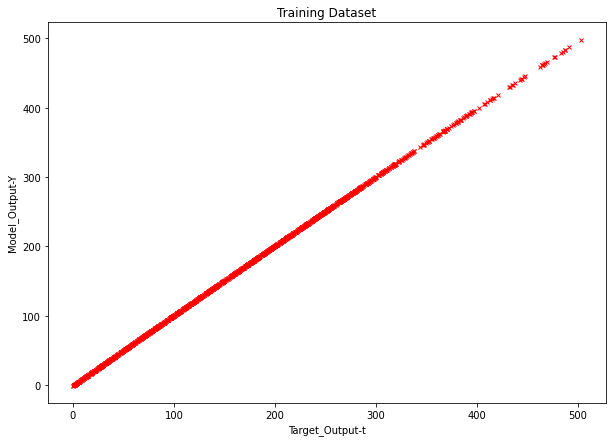

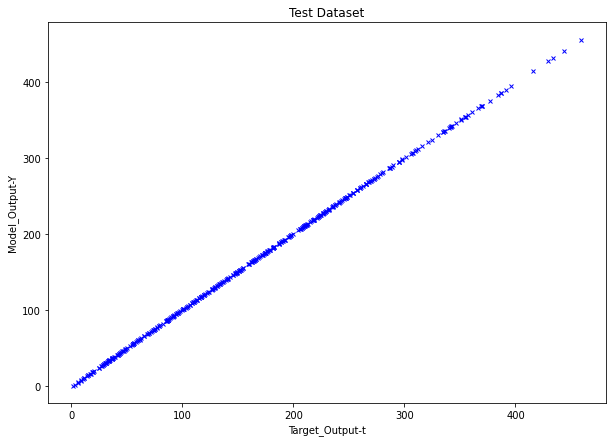

In [14]:
##############################################################################
######################------without regularization------#########################
##############################################################################

#Function to generate Gaussian basis function
def generate_phi(converged_mean,X_train,N_train,k,sigma):
    phi = np.zeros((N_train ,k), dtype = float)
    for i in range(N_train):
        a = X_train[i,:] - converged_mean
        b = np.sum(np.square(a),axis = 1)
        c = np.reshape(b,(k,1))
        for j in range(k):
            phi[i,j] = math.exp(-0.5*c[j]/(np.square(sigma)))    #Gaussian function approach for basis function
    return phi
#-----------------------------------------------------------------------------------------------------#

# Using Cross Validation to optimize 'w' parameter
def optimize_para(converged_mean,X,t,N_train,k,C,sigma):
    w_star_intermediate = np.zeros((C,k),dtype =float)
    error = np.zeros((C,1),dtype = float)
    erms_train = np.zeros((C,1),dtype = float)
    for i in range(C):
        phi_train = generate_phi(converged_mean,X[(N_train*i) : (N_train*(i+1)),:],N_train,k,sigma)
            
        #optimize parameter after training the data
        A2 = np.dot(np.transpose(phi_train),phi_train)
        B2 = np.linalg.inv(A2)
        pseudo_inv_phi = np.dot(B2,np.transpose(phi_train))
        w_star_intermediate[i,:] = np.dot(pseudo_inv_phi,t[(N_train*i):(N_train*(i+1))])   
        #calculating error
        error[i] = 0.5*np.sum(np.power((np.dot(phi_train,w_star_intermediate[i,:]) - t[(N_train*i):(N_train*(i+1))] ),2))
        erms_train[i] = math.pow(((2*error[i])/N_train),0.5)
        
    #Choosing index for minimum of all the error values calculated using cross validation
    a = np.argmin(error)
    w_star_optimum = w_star_intermediate[a,:]            #Optimum value of 'w' parameter
    return w_star_optimum,phi_train,a   
#-----------------------------------------------------------------------------------------------------#

#function for the output of testing model
def output_model_test(X,t,converged_mean,X_test,N_train,N_test,k,sigma):
    #Generating Gaussian Function phi
    phi_test = generate_phi(converged_mean,X_test,N_test,k,sigma)
        
    w_star_optimum,phi_train,a  = optimize_para(converged_mean,X,t,N_train,k,C,sigma)
    #model output for testing data
    Y_test = np.dot(phi_test,w_star_optimum)
    return Y_test,phi_train,w_star_optimum,a
#-----------------------------------------------------------------------------------------------------#

#Testing and Training Data Output
F1,phi_train,w_star_optimum,a = output_model_test(X,t,converged_mean,X_test,N_train,N_test,k,sigma)
Y_test = np.reshape(F1,(N_test,1))           #Model Output

print("+++++++++++++++++++++ WITHOUT REGULARIZATION +++++++++++++++++++++ \n")
# Calculating Training Data Error
Y_train = np.dot(phi_train,w_star_optimum) 
error_train=0.5*(np.sum(np.power((Y_train-t_train),2)))
erms_train=math.pow(((2*error_train)/N_train),0.5)
print("Train Error(Without Regularization)")
print(erms_train)
# Calculating Testing Data Error
error=0.5*(np.sum(np.power((F1-t_test),2)))
erms_test=math.pow(((2*error)/N_test),0.5)
print("Test Error(Without Regularization)")
print(erms_test)
#-----------------------------------------------------------------------------------------------------#
#Validating Data Output
Y_validate,phi_train,w_star_optimum,a = output_model_test(X,t,converged_mean,X_validate,N_train,N_validate,k,sigma)
error_validate=0.5*np.sum(np.power((Y_validate-t_validate),2))
erms_validate=np.power(((2*error_validate)/N_validate),0.5)
print("Validate Error(Without Regularization)")
print(erms_validate)
print("\n")
#-----------------------------------------------------------------------------------------------------#

# Scatter Plot (Without Regularization)
fig1 = plt.figure(figsize = (10, 7))
ax = fig1.add_subplot(111)   
ax.plot(t[(N_train*a):(N_train*(a+1))],Y_train,"rx",MarkerSize=4)
plt.title("Training Dataset")
plt.ylabel("Model_Output-Y")
plt.xlabel("Target_Output-t")


fig2 = plt.figure(figsize = (10, 7))
ax2 = fig2.add_subplot(111) 
ax2.plot(t_test,Y_test,"bx",MarkerSize=4)
plt.title("Test Dataset")
plt.ylabel("Model_Output-Y")
plt.xlabel("Target_Output-t")



# With Quadratic Regularization

+++++++++++++++++++++ WITH QUADRATIC REGULARIZATION +++++++++++++++++++++ 

Train Error (With Quadratic Regularizer)
0.9932475990164028
Test Error (With Quadratic Regularizer)
0.8861181006633922
Validate Error (With Quadratic Regularizer)
1.030464332924339




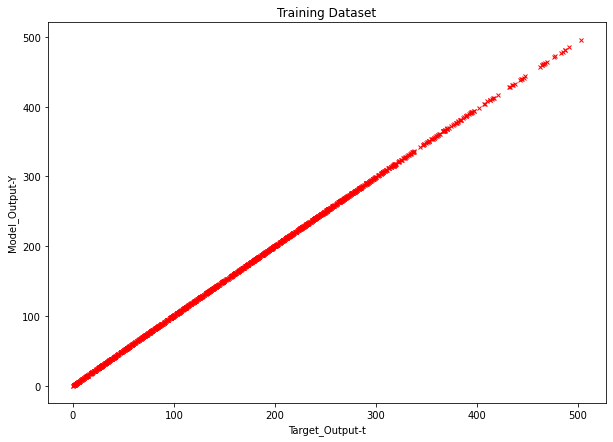

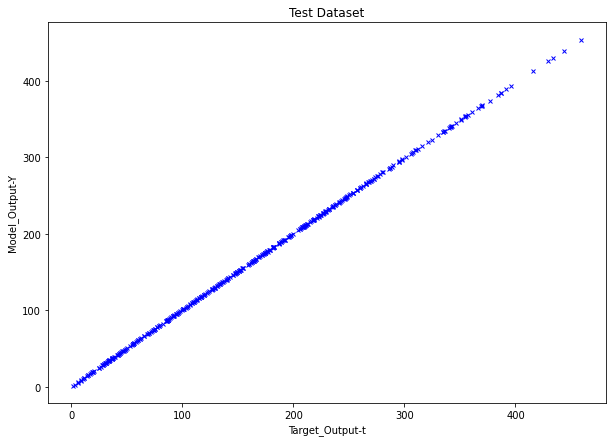

In [15]:
##############################################################################
######################------With Quadratic Regularization------#########################
##############################################################################


# Using Cross Validation to optimize 'w' parameter
def optimize_para_qr(converged_mean,X,t,N_train,k,C,sigma,lamda):
    w_star_intermediate = np.zeros((C,k),dtype =float)
    error = np.zeros((C,1),dtype = float)
    for i in range(C):
        phi_train = generate_phi(converged_mean,X[(N_train*i) : (N_train*(i+1)),:],N_train,k,sigma)
            
        #optimize parameter after training the data
        A2 = np.dot(np.transpose(phi_train),phi_train)
        B2 = np.linalg.inv(A2 + lamda*np.identity(k,dtype =float))
        pseudo_inv_phi = np.dot(B2,np.transpose(phi_train))
        w_star_intermediate[i,:] = np.dot(pseudo_inv_phi,t[(N_train*i):(N_train*(i+1))])   
        #calculating error
        error[i] = 0.5*np.sum(np.power((np.dot(phi_train,w_star_intermediate[i,:]) - t[(N_train*i):(N_train*(i+1))] ),2))
        
    #Choosing index for minimum of all the error values calculated using cross validation
    a = np.argmin(error)
    w_star_optimum = w_star_intermediate[a,:]                                #Optimum value of 'w' parameter
    return w_star_optimum,phi_train  
#-----------------------------------------------------------------------------#

#function for the output of testing model
def output_model_test_qr(X,t,converged_mean,X_test,N_train,N_test,k,sigma,lamda):
    #Generating Gaussian Function phi
    phi_test_qr = generate_phi(converged_mean,X_test,N_test,k,sigma)
        
    w_star_optimum_qr, phi_train_qr = optimize_para_qr(converged_mean,X,t,N_train,k,C,sigma,lamda)
    #model output for testing data
    Y_test_qr = np.dot(phi_test_qr,w_star_optimum_qr)
    return Y_test_qr,phi_train_qr,w_star_optimum_qr,a

#-----------------------------------------------------------------------------#

#Testing and Training Data Output
F_qr,phi_train_qr,w_star_optimum_qr,a = output_model_test_qr(X,t,converged_mean,X_test,N_train,N_test,k,sigma,lamda)
Y_test_qr = np.reshape(F_qr,(N_test,1))           #Model 
print("+++++++++++++++++++++ WITH QUADRATIC REGULARIZATION +++++++++++++++++++++ \n")
# Calculating Training Data Error
Y_train_qr = np.dot(phi_train_qr,w_star_optimum_qr) 
error_train_qr=0.5*(np.sum(np.power((Y_train_qr-t_train),2)))
erms_train_qr =math.pow(((2*error_train_qr)/N_train),0.5)
print("Train Error (With Quadratic Regularizer)")
print(erms_train_qr)
# Calculating Testing Data Error
error_test_qr=0.5*(np.sum(np.power((F_qr-t_test),2)))
erms_test_qr=math.pow(((2*error_test_qr)/N_test),0.5)
print("Test Error (With Quadratic Regularizer)")
print(erms_test_qr)
#-----------------------------------------------------------------------------#
#Validating Data Output
Y_validate_qr,phi_train_qr,w_star_optimum_qr,a = output_model_test_qr(X,t,converged_mean,X_validate,N_train,N_validate,k,sigma,lamda)
error_validate_qr=0.5*np.sum(np.power((Y_validate_qr-t_validate),2))
erms_validate_qr=np.power(((2*error_validate_qr)/N_validate),0.5)
print("Validate Error (With Quadratic Regularizer)")
print(erms_validate_qr)
print("\n")
#-----------------------------------------------------------------------------#
# Scatter Plot (With Quadratic Regularization)
# For training data
fig3 = plt.figure(figsize = (10, 7))
ax3 = fig3.add_subplot(111)   
ax3.plot(t[(N_train*a):(N_train*(a+1))],Y_train_qr,"rx",MarkerSize=4)
plt.title("Training Dataset")
plt.ylabel("Model_Output-Y")
plt.xlabel("Target_Output-t")
plt.show()
#For testing data
fig4 = plt.figure(figsize = (10, 7))
ax4 = fig4.add_subplot(111) 
ax4.plot(t_test,Y_test_qr,"bx",MarkerSize=4)
plt.title("Test Dataset")
plt.ylabel("Model_Output-Y")
plt.xlabel("Target_Output-t")
plt.show()


# With Tikonov Regularization

+++++++++++++++++++++ WITH TIKHONOV REGULARIZATION +++++++++++++++++++++ 

Train Error (With Tikonov Regularizer)
0.7016497066556552
Test Error (With Tikonov Regularizer)
0.6063248570859283
Validate Error (With Tikonov Regularizer)
0.7221719879384375




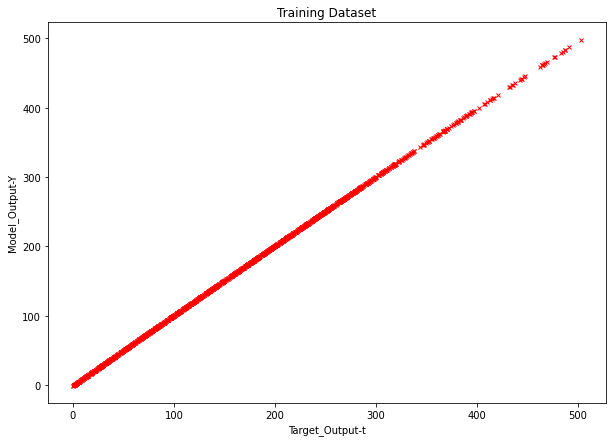

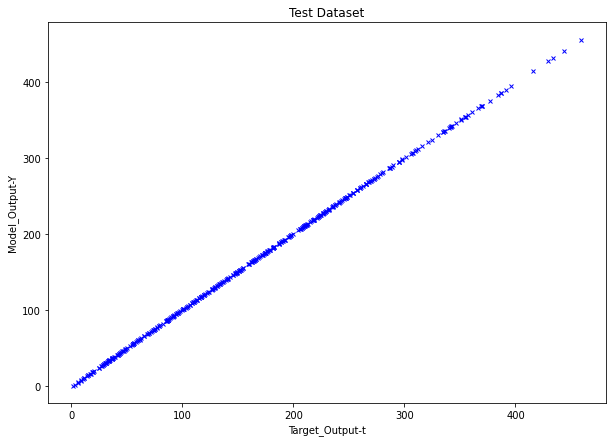

In [16]:
##############################################################################
######################------With Tikonov Regularization------#########################
##############################################################################

def phi_tilda(converged_mean,k,sigma):
    phi_tilda = np.zeros((k ,k), dtype = float)
    for i in range(k):
        for j in range(k):
            a = converged_mean[i,:] - converged_mean[j,:]
            b = np.reshape(a,(2,1))
            c = np.sum(np.square(b),axis = 0)
            phi_tilda[i,j] = math.exp(-0.5*c/(np.square(sigma)))    #Gaussian function approach for basis function        
    return phi_tilda

# Using Cross Validation to optimize 'w' parameter
def optimize_para_tr(converged_mean,X,t,N_train,k,C,sigma,lamda):
    w_star_intermediate = np.zeros((C,k),dtype =float)
    error = np.zeros((C,1),dtype = float)
    for i in range(C):
        phi_train = generate_phi(converged_mean,X[(N_train*i) : (N_train*(i+1)),:],N_train,k,sigma)
            
        #optimize parameter after training the data
        A2 = np.dot(np.transpose(phi_train),phi_train)
        B2 = np.linalg.inv(A2 + lamda*(phi_tilda(converged_mean,k,sigma)))
        pseudo_inv_phi = np.dot(B2,np.transpose(phi_train))
        w_star_intermediate[i,:] = np.dot(pseudo_inv_phi,t[(N_train*i):(N_train*(i+1))])  
        #calculating error
        error[i] = 0.5*np.sum(np.power((np.dot(phi_train,w_star_intermediate[i,:]) - t[(N_train*i):(N_train*(i+1))] ),2))
        
    #Choosing index for minimum of all the error values calculated using cross validation
    a = np.argmin(error)
    w_star_optimum = w_star_intermediate[a,:]         #optimal value of parameter 'w'
    return w_star_optimum ,phi_train 

#function for the output of testing model
def output_model_test_tr(X,t,converged_mean,X_test,N_train,N_test,k,sigma,lamda):
    #Generating Gaussian Function phi
    phi_test_tr = generate_phi(converged_mean,X_test,N_test,k,sigma)
        
    w_star_optimum_tr, phi_train_tr = optimize_para_tr(converged_mean,X,t,N_train,k,C,sigma,lamda)
    #model output for testing data
    Y_test_tr = np.dot(phi_test_tr,w_star_optimum_tr)
    return Y_test_tr,phi_train_tr,w_star_optimum_tr,a

#-----------------------------------------------------------------------------#

#Testing and Training Data Output
F_tr,phi_train_tr,w_star_optimum_tr,a = output_model_test_tr(X,t,converged_mean,X_test,N_train,N_test,k,sigma,lamda)
Y_test_tr = np.reshape(F_tr,(N_test,1))           #Model Output
print("+++++++++++++++++++++ WITH TIKHONOV REGULARIZATION +++++++++++++++++++++ \n")
# Calculating Training Data Error
Y_train_tr = np.dot(phi_train_tr,w_star_optimum_tr) 
error_train_tr=0.5*(np.sum(np.power((Y_train_tr-t_train),2)))
erms_train_tr =math.pow(((2*error_train_tr)/N_train),0.5)
print("Train Error (With Tikonov Regularizer)")
print(erms_train_tr)

# Calculating Testing Data Error
error_test_tr=0.5*(np.sum(np.power((F_tr-t_test),2)))
erms_test_tr=math.pow(((2*error_test_tr)/N_test),0.5)
print("Test Error (With Tikonov Regularizer)")
print(erms_test_tr)
#-----------------------------------------------------------------------------#
#Validating Data Output
Y_validate_tr,phi_train_tr,w_star_optimum_tr,a = output_model_test_tr(X,t,converged_mean,X_validate,N_train,N_validate,k,sigma,lamda)
error_validate_tr=0.5*np.sum(np.power((Y_validate_tr-t_validate),2))
erms_validate_tr=np.power(((2*error_validate_tr)/N_validate),0.5)
print("Validate Error (With Tikonov Regularizer)")
print(erms_validate_tr)
print("\n")
#-----------------------------------------------------------------------------#
# Scatter Plot (With Tikonov Regularization)
# For training data
fig5 = plt.figure(figsize = (10, 7))
ax5 = fig5.add_subplot(111)   
ax5.plot(t[(N_train*a):(N_train*(a+1))],Y_train_tr,"rx",MarkerSize=4)
plt.title("Training Dataset")
plt.ylabel("Model_Output-Y")
plt.xlabel("Target_Output-t")
plt.show()
# For testing data
fig6 = plt.figure(figsize = (10, 7))
ax6 = fig6.add_subplot(111) 
ax6.plot(t_test,Y_test_tr,"bx",MarkerSize=4)
plt.title("Test Dataset")
plt.ylabel("Model_Output-Y")
plt.xlabel("Target_Output-t")
plt.show()
